In [1]:
# imports

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ncistd import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [3]:
# look at data

data_dir = Path('../../data/1-simulation/')
results_df = pd.read_csv(data_dir / 'cv_data_combined.csv')

results_df


,simulation_id,simulation_rank,simulation_shape,simulation_densities,simulation_mean_gene_sparsity,noise_level,rank,lambda,modeled_replicate,comparison_replicate,...,model_fms,true_fms,model_factor0_cosine_similarity,true_factor0_cosine_similarity,model_factor0_support_cosine_similarity,true_factor0_support_cosine_similarity,recovery,relevance,precision,recall
0,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,A,...,NaN,0.967317,NaN,0.975499,NaN,0.863145,0.74502,0.733815,0.996628,0.270695
1,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,B,...,0.998170,NaN,0.998267,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,C,...,0.998233,NaN,0.998324,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,B,...,NaN,0.970475,NaN,0.977646,NaN,0.863145,0.74502,0.733815,0.996628,0.270695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75595,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,B,B,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.00000,0.000000,0.000000,0.000000
75596,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,B,C,...,0.000000,NaN,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN
75597,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,C,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75598,99,2,"(762, 85, 94)","[0.3122649246608975, 0.3120617057446071, 0.044...",237.945873,1.033500,12,100.0,C,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Look at different simulation parameters

In [30]:
# show parameters of simulations run

results_df[[
    'simulation_id', 
    'simulation_rank', 
    'simulation_shape', 
    'simulation_densities', 
    'simulation_mean_gene_sparsity', 
    'noise_level'
]].drop_duplicates().sort_values('noise_level', ascending=False).head(50)


,simulation_id,simulation_rank,simulation_shape,simulation_densities,simulation_mean_gene_sparsity,noise_level
65772,87,9,"(352, 25, 10)","[0.7175498753208635, 0.470836863864021, 0.1843...",252.577556,9.707316
65016,86,9,"(296, 97, 100)","[0.24854347079839356, 0.9426478234026424, 0.20...",73.568867,8.901154
36288,48,9,"(365, 42, 72)","[0.20337863400183664, 0.0647478560905882, 0.61...",74.233201,8.804168
62748,83,9,"(590, 48, 98)","[0.7384986283564435, 0.9394992821307154, 0.467...",435.714191,7.066188
66528,88,5,"(439, 85, 84)","[0.615670641020824, 0.44695311861855125, 0.150...",270.279411,6.329591
2268,3,9,"(368, 81, 68)","[0.615882002651789, 0.7133708312715766, 0.6002...",226.644577,6.271102
63504,84,8,"(692, 10, 44)","[0.04911840125963074, 0.9175141379582568, 0.44...",33.989934,6.187579
68796,91,2,"(679, 64, 47)","[0.8865722097837397, 0.4954754433169358, 0.699...",601.982530,6.176310
45360,60,2,"(46, 11, 90)","[0.6495183149537201, 0.27699372583863313, 0.06...",29.877842,5.534738
9072,12,9,"(693, 68, 48)","[0.22096921628667465, 0.1921708024793497, 0.63...",153.131667,5.506841


# Look at single simulation data

In [50]:
# down select to a single simulation

sim_id = 90

sim_df = results_df[results_df['simulation_id'] == sim_id]

# show simulation parameters
print(json.dumps(sim_df[[
    'simulation_id', 
    'simulation_rank', 
    'simulation_shape', 
    'simulation_densities', 
    'simulation_mean_gene_sparsity', 
    'noise_level'
]].drop_duplicates().to_dict('records')[0], indent=4))

# look at cross validation results
sim_df[sim_df['modeled_replicate'] != sim_df['comparison_replicate']].groupby(
    ['rank', 'lambda']
)[['relative_sse', 'model_fms', 'mean_gene_sparsity']].mean().sort_values('relative_sse')


{
    "simulation_id": 90,
    "simulation_rank": 5,
    "simulation_shape": "(835, 44, 66)",
    "simulation_densities": "[0.5904356088891239, 0.8176872809032707, 0.5355232341605448]",
    "simulation_mean_gene_sparsity": 493.0137334224185,
    "noise_level": 1.2964721802525865
}


relative_sse  model_fms  mean_gene_sparsity
rank lambda                                              
5    0.100        0.628159   0.996085          766.666667
     0.010        0.628247   0.995760          814.933333
     0.001        0.628259   0.995719          820.333333
6    0.100        0.628508   0.830725          757.888889
     0.010        0.628679   0.831260          814.500000
...                    ...        ...                 ...
3    100.000      1.000000   0.000000            0.000000
2    100.000      1.000000   0.000000            0.000000
1    100.000      1.000000   0.000000            0.000000
10   100.000      1.000000   0.000000            0.000000
12   100.000      1.000000   0.000000            0.000000

[84 rows x 3 columns]

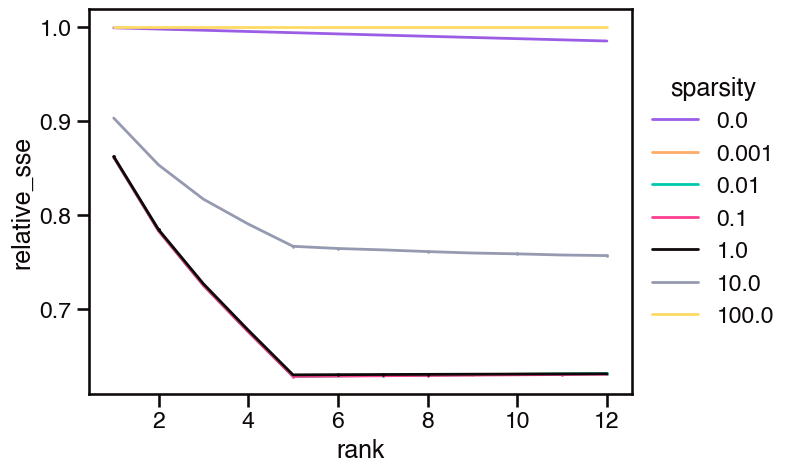

In [51]:
# look at relative_sse vs rank

plot_df = sim_df[sim_df['modeled_replicate'] != sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] == 10.0]
# plot_df = plot_df[plot_df['rank'] >= 8]

y_val = 'relative_sse'

fig, axis = plt.subplots(figsize=(7, 5))
# for i, rank in enumerate(df['rank'].unique()):
for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['rank'] == rank]
    data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
#         label=rank
        label=lamb
    );
#     sns.scatterplot(
# #         x='lambda', 
#         x='rank', 
#         y=y_val, 
#         style='replicate_pair',
#     #     hue='rank', 
# #         color='black', 
#         alpha=0.2, 
#         color=sns.color_palette()[i], 
#         data=data_df, 
#         ax=axis, 
#         legend=False
#     );
# plt.xscale('log', base=2);
# plt.yscale('log', base=10)
plt.legend(title='sparsity', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_relative_sse-v-rank-by-lambda.png'.format(sim_id), bbox_inches='tight')


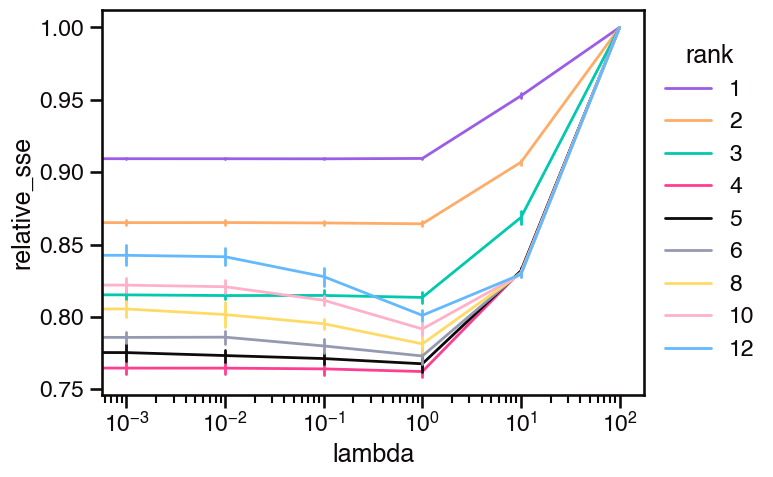

In [39]:
# look at relative_sse vs lambda

plot_df = sim_df[sim_df['modeled_replicate'] != sim_df['comparison_replicate']]
plot_df = plot_df[plot_df['rank'].isin([1, 2, 3, 4, 5, 6, 8, 10, 12])]
# plot_df = plot_df[plot_df['lambda'] <= 1.0]

fig, axis = plt.subplots(figsize=(7, 5))
for i, rank in enumerate(plot_df['rank'].unique()):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
#     sns.scatterplot(
#         x='lambda', 
#         y='relative_sse', 
#         style='replicate_pair',
#     #     hue='rank', 
# #         color='black', 
#         alpha=0.2, 
#         color=sns.color_palette()[i], 
#         data=data_df, 
#         ax=axis, 
#         legend=False
#     );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_relative_sse-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


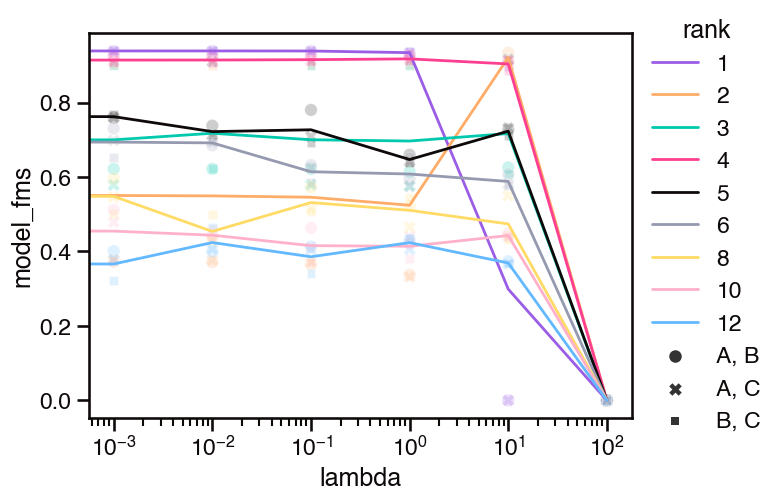

In [40]:
# look at fms (between replicates) vs lambda

y_val = 'model_fms'
plot_df = sim_df[sim_df[y_val].notna()]
plot_df = plot_df[plot_df['rank'].isin([1, 2, 3, 4, 5, 6, 8, 10, 12])]

fig, axis = plt.subplots(figsize=(7, 5))
subsets = plot_df['rank'].unique()
for i, rank in enumerate(subsets):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci=None, 
#         ci='sd', 
#         err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
    sns.scatterplot(
        x='lambda', 
        y=y_val, 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        alpha=0.2, 
        data=data_df, 
        ax=axis, 
        legend=(i==len(subsets)-1)
    );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_model_fms-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at fms (between replicates) vs rank

plot_df = sim_df[sim_df['modeled_replicate'] != sim_df['comparison_replicate']]

y_val = 'model_fms'

fig, axis = plt.subplots(figsize=(7, 5))
# for i, rank in enumerate(df['rank'].unique()):
for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['rank'] == rank]
    data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
#         label=rank
        label=lamb
    );
    sns.scatterplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=False
    );
# plt.xscale('log', base=2);
# plt.yscale('log', base=10)
plt.legend(title='sparsity', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_model_fms-v-rank-by-lambda.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at n_components vs lambda

plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] < .1]

fig, axis = plt.subplots(figsize=(7, 5))
subsets = plot_df['rank'].unique()
for i, rank in enumerate(subsets):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y='n_components', 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
    sns.scatterplot(
        x='lambda', 
        y='n_components', 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=(i==len(subsets)-1)
    );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_n_components-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at mean_gene_sparsity vs lambda

plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] < .1]
plot_df = plot_df[plot_df['lambda'] != 0.0]

fig, axis = plt.subplots(figsize=(7, 5))
subsets = plot_df['rank'].unique()
for i, rank in enumerate(subsets):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y='mean_gene_sparsity', 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
    sns.scatterplot(
        x='lambda', 
        y='mean_gene_sparsity', 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=False
    );
plt.xscale('log', base=10);
# plt.yscale('log', base=10)
plt.legend(title='rank');
# plt.savefig('../figures/sim{}_mean_gene_sparsity-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at fms against true factors vs rank

y_val = 'true_fms'
plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] <= 1.0]

fig, axis = plt.subplots(figsize=(7, 5))
# for i, rank in enumerate(df['rank'].unique()):
for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['rank'] == rank]
    data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
#         label=rank
        label=lamb
    );
    sns.scatterplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
        style='modeled_replicate',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=False
    );
# plt.xscale('log', base=2);
# plt.yscale('log', base=10)
plt.legend(title='sparsity', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_true_fms-v-rank-by-lambda.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at the cosine similarity of the modeled gene factors against the true gene factors vs rank

y_val = 'true_factor0_support_cosine_similarity'
plot_df = sim_df[sim_df['modeled_replicate'] == sim_df['comparison_replicate']]
# plot_df = plot_df[plot_df['lambda'] <= 1.0]

fig, axis = plt.subplots(figsize=(7, 5))
# for i, rank in enumerate(df['rank'].unique()):
for i, lamb in enumerate(plot_df['lambda'].unique()):
#     data_df = plot_df[plot_df['rank'] == rank]
    data_df = plot_df[plot_df['lambda'] == lamb]
    sns.lineplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci='sd', 
        err_style='bars', 
        data=data_df,
        ax=axis, 
#         label=rank
        label=lamb
    );
    sns.scatterplot(
#         x='lambda', 
        x='rank', 
        y=y_val, 
        style='modeled_replicate',
    #     hue='rank', 
#         color='black', 
        alpha=0.2, 
        color=sns.color_palette()[i], 
        data=data_df, 
        ax=axis, 
        legend=False
    );
# plt.xscale('log', base=2);
# plt.yscale('log', base=10)
plt.legend(title='sparsity', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_true_f0_support_cossim-v-rank-by-lambda.png'.format(sim_id), bbox_inches='tight')


In [ ]:
# look at the cosine similarity of the modeled gene factors against the true gene factors vs rank

y_val = 'true_factor0_cosine_similarity'
# y_val = 'model_fms'
plot_df = sim_df[sim_df[y_val].notna()]

fig, axis = plt.subplots(figsize=(7, 5))
subsets = plot_df['rank'].unique()
for i, rank in enumerate(subsets):
    data_df = plot_df[plot_df['rank'] == rank]
    sns.lineplot(
        x='lambda', 
        y=y_val, 
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        ci=None, 
#         ci='sd', 
#         err_style='bars', 
        data=data_df,
        ax=axis, 
        label=rank
    );
    sns.scatterplot(
        x='lambda', 
        y=y_val, 
        style='replicate_pair',
    #     hue='rank', 
#         color='black', 
        color=sns.color_palette()[i], 
        alpha=0.2, 
        data=data_df, 
        ax=axis, 
        legend=(i==len(subsets)-1)
    );
plt.xscale('log', base=10);
plt.legend(title='rank', loc='center left', bbox_to_anchor=[1, 0.5]);
# plt.savefig('../figures/sim{}_true_f0_support_cossim-v-lambda-by-rank.png'.format(sim_id), bbox_inches='tight')


In [ ]:
for sim_id in [1, 4, 5, 6, 8]:
    for rank in [3, 5, 7]:
        for sparsity in [0.1, 1.0, 10.0]:
            decomp_path = data_dir / 'sim{}/replicate{}/rank{}/lambda{}'.format(
                    sim_id, 
                    'A', 
                    rank, 
                    sparsity
                )
            cp = load_cp_tensor(decomp_path / 'fitted_model.h5')
            print('\nSimulation {}: {}'.format(
                sim_id, 
                cp
            ))
            for mode in range(3):
                print(np.linalg.norm(cp.factors[mode], axis=0))

# Look at specific decompositions

In [ ]:
# look at factors of all optimal parameters decomposition

data_dir = Path('../data')
heatmap_params = {'vmin':None, 'vmax':None, 'cmap':'coolwarm', 'center':0}

# # make dict of optimal parameters
# optimal_params = optimal_df.groupby('simulation_id')[
#     ['rank', 'lambda', 'noise_level']].mean().reset_index().to_dict('records')
# # iterate through them
# for params in optimal_params:
#     # get optimal parameters for each simulation


sim_id = 8
replicate = 'A'

rank = 4
sparsity = 1.

#     rank = int(params['rank'])
#     sparsity = params['lambda']

# build filepaths of true cp and optimal decomposition
true_path = data_dir / 'sim{}'.format(
    sim_id, 
)
decomp_path = data_dir / 'sim{}/replicate{}/rank{}/lambda{}'.format(
    sim_id, 
    replicate, 
    rank, 
    sparsity
)

# load cps
true_cp = load_cp_tensor(true_path / 'simulation_ground_truth.h5')
cp = load_cp_tensor(decomp_path / 'fitted_model.h5')
print('\nSimulation {}: {}\n\tnoise level={:.2}\n\toptimal rank={}\n\toptimal lambda={}'.format(
    sim_id, 
    true_cp,
#     params['noise_level'], 
    'na', 
    rank, 
    sparsity
))

# calculate fms and get optimal permutation
fms, perm = factor_match_score(true_cp, cp, return_permutation=True, allow_smaller_rank=True)
cp_perm = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print('\tFMS: {}'.format(fms))

# plot
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(cp_perm).factors, 
    reference_factors=tl.cp_normalize(true_cp).factors, 
    mask_thold=[0, 0], 
    ratios=False, 
    heatmap_kwargs=heatmap_params)
plt.show()


In [ ]:
# look at similarity of sparsity supports

sup_true_cp = tl.cp_tensor.CPTensor((true_cp.weights, [(true_cp.factors[0] != 0)]))
# sup_true_cp = tl.cp_tensor.CPTensor((true_cp.weights, [true_cp.factors[0]]))
sup_cp = tl.cp_tensor.CPTensor((cp.weights, [(cp.factors[0] != 0)]))
# sup_cp = tl.cp_tensor.CPTensor((cp.weights, [cp.factors[0]]))

print(
    'cosine similarity factor0 support: {}'.format(
        tlviz.factor_tools.cosine_similarity(sup_true_cp.factors[0], sup_cp.factors[0])
    )
)
print(
    'cosine similarity factor0 values: {}'.format(
        tlviz.factor_tools.cosine_similarity(true_cp.factors[0], cp.factors[0])
    )
)


In [ ]:
# compare sparsity supports of gene factor to ground truth

# calculate fms and get optimal permutation
fms, perm = factor_match_score(true_cp, cp, return_permutation=True, allow_smaller_rank=True)
cp_perm = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print(fms)

# plot
heatmap_params = {'vmin':None, 'vmax':None, 'cmap':'coolwarm', 'center':0}
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(cp_perm).factors, 
    reference_factors=tl.cp_normalize(true_cp).factors, 
#     cp_perm.factors, 
#     reference_factors=sim.factors, 
    mask_thold=[0, 0], 
    ratios=False, 
    heatmap_kwargs=heatmap_params)
plt.show()
fig.savefig('../figures/cp_comparison_sim{}_rank{}_lambda{}.png'.format(sim_id, rank, sparsity))


In [ ]:
# compare decomposition factors to ground truth

# calculate fms and get optimal permutation
fms, perm = factor_match_score(true_cp, cp, return_permutation=True, allow_smaller_rank=True)
cp_perm = tlviz.factor_tools.permute_cp_tensor(cp, perm)
print(fms)

# plot
heatmap_params = {'vmin':None, 'vmax':None, 'cmap':'coolwarm', 'center':0}
fig, ax = plot_factors_heatmap(
    tl.cp_normalize(cp_perm).factors, 
    reference_factors=tl.cp_normalize(true_cp).factors, 
#     cp_perm.factors, 
#     reference_factors=sim.factors, 
    mask_thold=[0, 0], 
    ratios=False, 
    heatmap_kwargs=heatmap_params)
plt.show()
# fig.savefig('../figures/cp_comparison.png')


# Look at simulated data tensors

In [ ]:
# read in data

data_dir = Path('../../figure-1/data')

sim_id = 0
bootstrap = 0
replicate = 'A'

sim_path = data_dir / 'sim{}'.format(sim_id)


In [ ]:
# look at true ground truth tensor

true_cp = load_cp_tensor(sim_path / 'simulation_ground_truth.h5')
fig = visualize_3d_tensor(
    true_cp.to_tensor(), 
    shell=False, 
    midpoint=0, 
    range_color=[-1, 1]
)
fig.show()


In [ ]:
# look at replicate dataset

da = xr.open_dataarray(sim_path / 'replicate{}/simulation_data_replicate_{}.nc'.format(replicate, replicate))
fig = visualize_3d_tensor(
    da.data, 
    shell=False, 
    midpoint=0, 
    range_color=[-1, 1]
)
fig.show()


In [ ]:
# look at shuffled replicate data

rep_path = sim_path / 'bootstrap{}/replicate{}'.format(b, rep) 
rep_array = xr.open_dataarray(rep_path / 'shuffled_replicate_{}.nc'.format(rep))
fig = visualize_3d_tensor(
    rep_array.data, 
    shell=False, 
    midpoint=0, 
    range_color=[-1, 1]
)
fig.show()
